In [3]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

import argparse
import sys

plt.rcParams['figure.figsize'] = [16, 9]

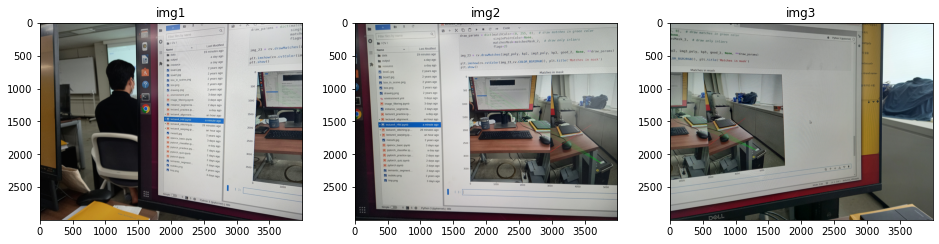

In [31]:
# read images
img_names = ['./data/com1.jpg','./data/com2.jpg', './data/com3.jpg']
img1 = cv.imread(img_names[0])
img2 = cv.imread(img_names[1])
img3 = cv.imread(img_names[2])

plt.subplot(1,3,1), plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB)), plt.title('img1')
plt.subplot(1,3,2), plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB)), plt.title('img2')
plt.subplot(1,3,3), plt.imshow(cv.cvtColor(img3, cv.COLOR_BGR2RGB)), plt.title('img3')
plt.show()

In [32]:
sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
kp3, des3 = sift.detectAndCompute(img3, None)

In [33]:
FLANN_INDEX_KDTREE = 1
index_params_1 = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params_1 = dict(checks=50)

index_params_2 = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params_2 = dict(checks=50)

matcher_1 = cv.FlannBasedMatcher(index_params_1, search_params_1)
matches_1 = matcher_1.knnMatch(des1, des2, k=2)

good_1 = []
for m, n in matches_1:
    if m.distance < 0.7 * n.distance: # Lowe's ratio test.
        good_1.append(m)

print(len(good_1))

matcher_2 = cv.FlannBasedMatcher(index_params_2, search_params_2)
matches_2 = matcher_2.knnMatch(des2, des3, k=2)

good_2 = []
for m, n in matches_2:
    if m.distance < 0.7 * n.distance: # Lowe's ratio test.
        good_2.append(m)

print(len(good_2))

1389
1122


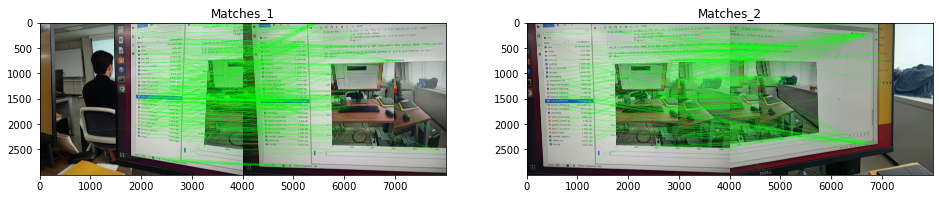

In [34]:
draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

img_matches_1 = cv.drawMatches(img1, kp1, img2, kp2, good_1, None, **draw_params)
img_matches_2 = cv.drawMatches(img2, kp2, img3, kp3, good_2, None, **draw_params)

plt.subplot(1,2,1), plt.imshow(cv.cvtColor(img_matches_1, cv.COLOR_BGR2RGB)), plt.title('Matches_1')
plt.subplot(1,2,2), plt.imshow(cv.cvtColor(img_matches_2, cv.COLOR_BGR2RGB)), plt.title('Matches_2')

plt.show()

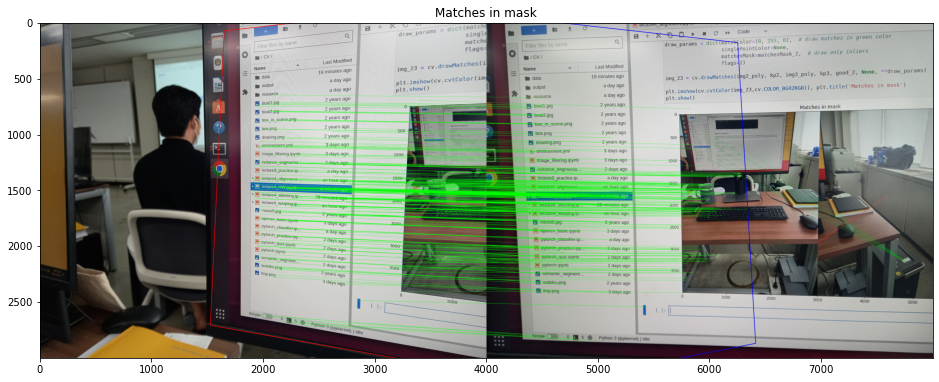

In [38]:
MIN_MATCH_COUNT = 10
if len(good_1) > MIN_MATCH_COUNT:

    src_pts_1 = np.float32([kp1[m.queryIdx].pt for m in good_1]).reshape(-1, 1, 2)
    dst_pts_1 = np.float32([kp2[m.trainIdx].pt for m in good_1]).reshape(-1, 1, 2)

    M_1, mask_1 = cv.findHomography(src_pts_1, dst_pts_1, cv.RANSAC, 5.0)
    matchesMask_1 = mask_1.ravel().tolist()

    h, w, c = img1.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst1 = cv.perspectiveTransform(pts, M_1)

    h, w, c = img2.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst2 = cv.perspectiveTransform(pts, np.linalg.inv(M_1))

    img2_poly = cv.polylines(img2.copy(), [np.int32(dst1)], True, (255,0,0), 3, cv.LINE_AA)
    img1_poly = cv.polylines(img1.copy(), [np.int32(dst2)], True, (0,0,255), 3, cv.LINE_AA)
else:
    print("Not enough matches are found - {}/{}".format(len(good_1), MIN_MATCH_COUNT))
    matchesMask_1 = None

draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   matchesMask=matchesMask_1,  # draw only inliers
                   flags=2)

img_12 = cv.drawMatches(img1_poly, kp1, img2_poly, kp2, good_1, None, **draw_params)

plt.imshow(cv.cvtColor(img_12,cv.COLOR_BGR2RGB)), plt.title('Matches in mask')
plt.show()

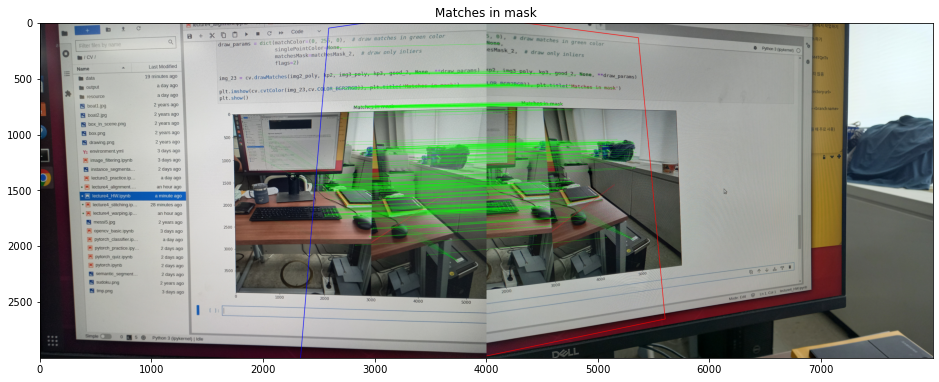

In [39]:
MIN_MATCH_COUNT = 10
if len(good_1) > MIN_MATCH_COUNT:

    src_pts_2 = np.float32([kp2[m.queryIdx].pt for m in good_2]).reshape(-1, 1, 2)
    dst_pts_2 = np.float32([kp3[m.trainIdx].pt for m in good_2]).reshape(-1, 1, 2)

    M_2, mask_2 = cv.findHomography(src_pts_2, dst_pts_2, cv.RANSAC, 5.0)
    matchesMask_2 = mask_2.ravel().tolist()

    h, w, c = img2.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst3 = cv.perspectiveTransform(pts, np.linalg.inv(M_2))

    h, w, c = img3.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst4 = cv.perspectiveTransform(pts, M_2)

    img2_poly = cv.polylines(img2.copy(), [np.int32(dst3)], True, (255,0,0), 3, cv.LINE_AA)
    img3_poly = cv.polylines(img3.copy(), [np.int32(dst4)], True, (0,0,255), 3, cv.LINE_AA)
else:
    print("Not enough matches are found - {}/{}".format(len(good_2), MIN_MATCH_COUNT))
    matchesMask_2 = None

draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   matchesMask=matchesMask_2,  # draw only inliers
                   flags=2)

img_23 = cv.drawMatches(img2_poly, kp2, img3_poly, kp3, good_2, None, **draw_params)

plt.imshow(cv.cvtColor(img_23,cv.COLOR_BGR2RGB)), plt.title('Matches in mask')
plt.show()

In [40]:
out_width = img2.shape[1]*2
out_height = img2.shape[0]*2
I = np.eye(3)
A = np.eye(3)
A[0:2,2] = [out_width//4, out_height//4] # width, height

# define mask
mask1 = np.ones_like(img1)
mask2 = np.ones_like(img2)
mask3 = np.ones_like(img3)

M_1_inv = np.linalg.inv(M_1)
M_2_inv = np.linalg.inv(M_2)

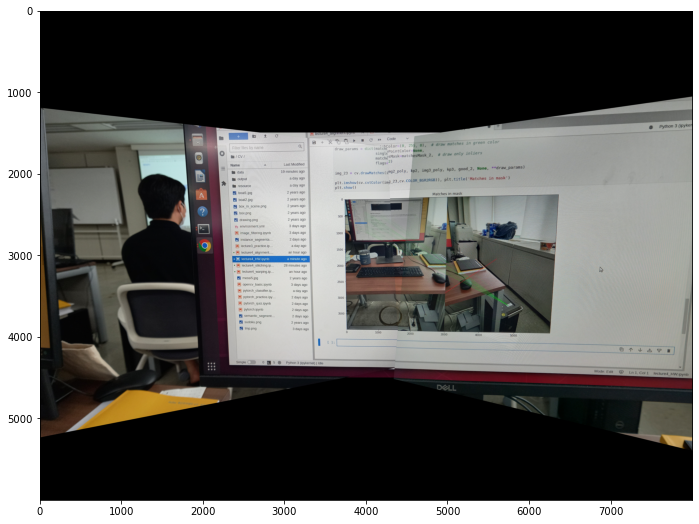

In [55]:
img1_out = cv.warpPerspective(img1, A@M_1, (out_width, out_height))
mask1_out = cv.warpPerspective(mask1, A@M_1, (out_width, out_height))

img2_out = cv.warpPerspective(img2, A@I, (out_width, out_height))
mask2_out = cv.warpPerspective(mask2, A@I, (out_width, out_height))

img3_out = cv.warpPerspective(img3, A@M_2_inv, (out_width, out_height))
mask3_out = cv.warpPerspective(mask3, A@M_2_inv, (out_width, out_height))

img_stitch = img2_out 
img_stitch = ((1-mask1_out) * img_stitch +  mask1_out * img1_out)
img_stitch = (1-mask3_out) * img_stitch +  mask3_out * img3_out

# display
img_stitch = np.clip(img_stitch,0,255).astype(np.uint8)
plt.imshow(cv.cvtColor(img_stitch, cv.COLOR_BGR2RGB))
plt.show()